# Lending Club - Interest Rate Predictor

## Current Notebook: 6_Model_XG Boost

---
**Author:** Rohit Singh
<br/>
[GitHub](https://github.com/rohitsinghxyz) | [LinkedIn](https://www.linkedin.com/in/rohitsinghxyz)
<br/>
<br/>
**Project:** Lending Club - Interest Rate Predictor
<br/>
<br/>
**Previous Notebook:** 5_Model_Random Forest
<br/>
**Current Notebook:** 6_Model_XG Boost
<br/>
**Next Notebook:** This is the last notebook (for now!)

## Table of Contents

[1. Data Import](#1)
<br/>
[2. Transformers](#2)
<br/>
[3. XG Boost: Model Training](#3)
<br/>
[4. XG Boost: Model Evaluation](#4)
<br/>
[5. XG Boost: Model Predictions](#5)
<br/>
[6. Observations](#6)
<br/>
[7. Future Steps](#7)

---
<a id="1"></a>
## 1. Data Import

In [1]:
# Import packages
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from tempfile import mkdtemp
import shap

/Users/rohit/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Let us import the Train, Validation, Remainder, and Test data sets.

In [2]:
# Import Train, Validation, Remainder, Test sets

X_remainder = joblib.load('data/X_remainder.pkl')
X_train = joblib.load('data/X_train.pkl')
X_test = joblib.load('data/X_test.pkl')
X_validation = joblib.load('data/X_validation.pkl')

y_remainder = joblib.load('data/y_remainder.pkl')
y_train = joblib.load('data/y_train.pkl')
y_test = joblib.load('data/y_test.pkl')
y_validation = joblib.load('data/y_validation.pkl')

In [3]:
# Print shapes of split sets
print(f'Shape of Test set: {X_test.shape}')
print(f'Shape of Validation set: {X_validation.shape}')
print(f'Shape of Train set: {X_train.shape}')

Shape of Test set: (416057, 15)
Shape of Validation set: (332846, 15)
Shape of Train set: (1331380, 15)


Data sets seem to have loaded correctly.

---
<a id="2"></a>
### 2. Transformers

In [4]:
# Check categorical columns
cat_columns = list(X_train.select_dtypes(include=['object', 'category']).columns)
cat_columns
print(f'Categorical columns are: {cat_columns}')

Categorical columns are: ['term', 'purpose', 'verification_status', 'home_ownership', 'disbursement_method', 'pub_rec_bin', 'pub_rec_bankruptcies_bin', 'tax_liens_bin']


In [5]:
# Check numerical columns
num_columns = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
num_columns
print(f'Numerical columns are: {num_columns}')

Numerical columns are: ['loan_amnt', 'annual_inc', 'dti', 'open_acc', 'mort_acc', 'num_bc_sats', 'fico_range_avg']


**Why encode categorical data using OneHotEncoder?**

We have few categorical columns in our data. Since order is not important in these categorical columns, we can encode them using OneHotEncoder. If order was important, we would have used OrdinalEncoder.

In [6]:
# Set up categorical pipeline
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

**Why scale numerical data using StandardScaler?**

We have few numerical columns in our data with varying scales of measurement. Hence, it makes sense to scale the data so that all attributes have the same scale. This helps machine learning algorithms perform better.

We are aware that tree-based models do not require data to be scaled.

In [7]:
# Set up numerical pipeline
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [8]:
# Set up column transformer
col_transformer = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)],
    remainder='passthrough',
    n_jobs=-1,
    verbose=3
)
col_transformer.fit(X_train)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['term', 'purpose', 'verification_status',
                                  'home_ownership', 'disbursement_method',
                                  'pub_rec_bin', 'pub_rec_bankruptcies_bin',
                                  'tax_liens_bin']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['loan_amnt', 'annual_inc', 'dti', 'open_acc',
                                  'mort_acc', 'num_bc_sats',
                                  'fico_range_avg'])],
                  verbose=3)

Let us check whether OneHotEncoder properly encoded the categorical columns or not.

In [9]:
# Prepare column names
cat_columns_names = col_transformer.named_transformers_['cat']['encoder'].get_feature_names(cat_columns)
columns = np.append(cat_columns_names, num_columns)

# Check column names
display(X_train)
display(pd.DataFrame(col_transformer.transform(X_train), columns=columns))

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,loan_amnt,term,purpose,annual_inc,verification_status,home_ownership,dti,open_acc,mort_acc,num_bc_sats,disbursement_method,fico_range_avg,pub_rec_bin,pub_rec_bankruptcies_bin,tax_liens_bin
237045,20000.0,60 months,debt_consolidation,85000.0,Verified,MORTGAGE,16.68,15.0,6.0,3.0,Cash,662.0,pub_rec_1+_bin,pub_rec_bankruptcies_1+_bin,tax_liens_0_bin
2066086,4000.0,36 months,home_improvement,112000.0,Source Verified,MORTGAGE,21.55,12.0,1.0,5.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1163134,35000.0,60 months,debt_consolidation,180000.0,Source Verified,MORTGAGE,15.55,23.0,1.0,12.0,Cash,757.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1189746,10000.0,36 months,debt_consolidation,66000.0,Not Verified,MORTGAGE,11.96,9.0,2.0,5.0,Cash,672.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1078531,6000.0,36 months,car,40000.0,Not Verified,OWN,20.28,4.0,2.0,2.0,Cash,737.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061037,30000.0,36 months,credit_card,130000.0,Source Verified,MORTGAGE,15.32,18.0,1.0,9.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
306590,28775.0,36 months,debt_consolidation,60000.0,Verified,MORTGAGE,18.56,8.0,1.0,5.0,Cash,697.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
850631,15000.0,36 months,credit_card,60000.0,Not Verified,RENT,21.82,9.0,0.0,6.0,DirectPay,702.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
740312,35000.0,36 months,debt_consolidation,90000.0,Source Verified,MORTGAGE,15.93,6.0,1.0,2.0,Cash,682.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin


,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,pub_rec_bankruptcies_bin_pub_rec_bankruptcies_1+_bin,tax_liens_bin_tax_liens_0_bin,tax_liens_bin_tax_liens_1+_bin,loan_amnt,annual_inc,dti,open_acc,mort_acc,num_bc_sats,fico_range_avg
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.566806,0.042796,-0.182339,0.582379,2.333721,-0.592870,-1.160244
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.201218,0.245596,0.394588,0.052904,-0.284009,0.062837,-0.695519
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.756349,-0.316205,1.994311,-0.284009,2.357812,1.783016
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.538209,-0.099914,-0.741496,-0.476570,0.239537,0.062837,-0.850427
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.980215,-0.295202,0.244137,-1.359027,0.239537,-0.920724,1.163382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.671822,0.380795,-0.343452,1.111853,-0.284009,1.374251,-0.695519
1331376,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.536457,-0.144981,0.040376,-0.653061,-0.284009,0.062837,-0.075885
1331377,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.014299,-0.144981,0.426574,-0.476570,-0.807555,0.390690,0.079023
1331378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.080352,-0.271188,-1.006044,-0.284009,-0.920724,-0.540611


We can see that OneHotEncoder has successfully encoded Categorical columns.

We can also see that Numerical columns have been scaled.

---
<a id="3"></a>
### 3. XG Boost: Model Training

Having tried the Random Forest model in the previous notebook, we will focus on the XG Boost model in this notebook to see if we can improve the model performance.

Instead of exploring multiple combinations one by one, we will use Pipeline and GridSearchCV/RandomizedSearchCV to find the best hyper-parameters for us. Ideally, we would have used Pipeline and GridSearchCV to try out all possible combinations. But due to the size of our data set and time/computing restraints, we will use Pipeline and RandomizedSearchCV for the time being. RandomizedSearchCV doesn't try out all possible combinations like GridSearchCV but only evaluates random combinations by selecting random values for each hyper-parameter.


**Scoring**

For scoring, we will RMSE (Root Mean Squared Error).

RMSE is an extension of the Mean Squared Error (MSE). The square root of the error is calculated, which means that the units of RMSE are the same as the original units of the target value that is being predicted.

RMSE represents the square root of the variance of the residuals. A perfect RMSE value is 0.0, which means that all predictions matched the expected values exactly. This is almost never the case.

In [11]:
%%time
# Run time ~ 20 hr

# XG Boost Regressor

# Cache memory in case of kernel crash
cachedir = mkdtemp()

# Set default values for pipeline
pipe = Pipeline([
        ('preprocessor', col_transformer),
        ('model', XGBRegressor())],
        memory=cachedir)

# Set up parameter grid
param_grid = [
    {
        # XG Boost Regressor
        'model': [XGBRegressor(n_estimators=100, random_state=123)],
        'model__max_depth': np.arange(5, 35, 5),
        'model__eta': [0.05, 0.1, 0.2, 0.3]
    }  
]

# Store results of RandomizedSearchCV as `xgb_grid`
xgb_grid = RandomizedSearchCV(pipe, param_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error',\
                          return_train_score=True, verbose=3)

# Fit grid on Train data
xgb_fitgrid = xgb_grid.fit(X_train, y_train)

The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


Persisting input arguments took 19.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=5;, score=(train=-3.591, test=-3.596) total time= 2.8min


Persisting input arguments took 14.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.8s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=5;, score=(train=-3.591, test=-3.603) total time= 2.7min


Persisting input arguments took 18.46s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.1s
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=5;, score=(train=-3.589, test=-3.600) total time= 2.8min


Persisting input arguments took 16.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=5;, score=(train=-3.593, test=-3.591) total time= 2.7min


Persisting input arguments took 16.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=5;, score=(train=-3.592, test=-3.590) total time= 2.8min
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.0s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.5s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=15;, score=(train=-3.001, test=-3.526) total time= 5.6min
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
   

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.05, model__max_depth=30;, score=(train=-0.632, test=-3.696) total time=23.6min
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
   

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.1, model__max_depth=10;, score=(train=-3.378, test=-3.504) total time= 2.8min
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.1, model__max_depth=20;, score=(train=-1.857, test=-3.602) total time= 7.7min
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.1, model__max_depth=30;, score=(train=-0.201, test=-3.716) total time=23.9min
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.2, model__max_depth=10;, score=(train=-3.302, test=-3.487) total time= 3.0min
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.2, model__max_depth=25;, score=(train=-0.534, test=-3.748) total time=14.5min
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.3, model__max_depth=5;, score=(train=-3.492, test=-3.518) total time= 2.1min
[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
     

[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.3, model__max_depth=15;, score=(train=-2.476, test=-3.615) total time= 6.6min
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__eta=0.3, model__max_depth=25;, score=(train=-0.219, test=-3.832) total time=12.0min
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
    

Persisting input arguments took 22.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.5s
CPU times: user 6d 11h 43min 10s, sys: 9h 1min 18s, total: 6d 20h 44min 28s
Wall time: 19h 59min 5s


In [12]:
# Best estimator
print('Best Estimator: %s' % xgb_fitgrid.best_estimator_)

Best Estimator: Pipeline(memory='/var/folders/c_/v_fkrbc17sgfc3pm6kln8_9w0000gn/T/tmpsgok278w',
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['term', 'purpose',
                                                   'verification_status',
                                                   'home_ownership',
                                                   'disbursement_method',
                                                   'pub_rec_bin',...
                              eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
                       

In [13]:
# Export fit grid
joblib.dump(xgb_fitgrid, 'data/xgb_fitgrid.pkl')

['data/xgb_fitgrid.pkl']

In [14]:
# Export fit grid best estimator
joblib.dump(xgb_fitgrid.best_estimator_, 'data/xgb_fitgrid_best_estimator.pkl')

['data/xgb_fitgrid_best_estimator.pkl']

---
<a id="4"></a>
### 4. XG Boost: Model Evaluation

Let us import the exported fit grid model 'pkl' file for further evaluation.

In [15]:
# Load exported model
xgb_fitgrid = joblib.load('data/xgb_fitgrid.pkl')

In [16]:
# Best hyper-parameters
xgb_fitgrid.best_estimator_.named_steps.model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

The best hyper-parameters selected by RandomizedSearchCV for XG Boost Regressor are:
- n_estimators = 100
- max_depth = 10
- eta = 0.2

In [17]:
# Best score
print('Best Score for XG Boost using RMSE scoring: %.4f' % xgb_fitgrid.best_score_)

Best Score for XG Boost using RMSE scoring: -3.4922


In [18]:
# Grid cross validation results - All columns
pd.DataFrame(xgb_fitgrid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__eta,param_model,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,163.003340,1.990852,2.756465,0.618737,5,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 5, 'model__eta': 0.05, 'm...",-3.596281,-3.602556,...,-3.596001,0.004826,12,-3.591178,-3.591197,-3.589447,-3.592649,-3.592442,-3.591383,0.001145
1,242.681683,4.839947,3.456760,0.676901,10,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 10, 'model__eta': 0.05, '...",-3.535317,-3.541054,...,-3.534199,0.005413,8,-3.454504,-3.452364,-3.451552,-3.454286,-3.453687,-3.453279,0.001140
2,371.204520,39.879893,5.890166,1.868267,15,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 15, 'model__eta': 0.05, '...",-3.530200,-3.538556,...,-3.531626,0.005297,7,-3.005451,-3.004732,-2.999418,-3.002149,-3.001378,-3.002626,0.002213
3,533.874176,5.433974,4.969111,0.244751,20,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 20, 'model__eta': 0.05, '...",-3.586399,-3.591651,...,-3.586278,0.004165,11,-2.152365,-2.148772,-2.152433,-2.145637,-2.158044,-2.151450,0.004153
4,910.883993,6.417961,9.791056,0.242856,25,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 25, 'model__eta': 0.05, '...",-3.648152,-3.656445,...,-3.649598,0.005675,15,-1.257607,-1.218980,-1.238536,-1.251527,-1.213161,-1.235962,0.017468
5,1393.091642,9.020771,13.219902,0.165340,30,0.05,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 30, 'model__eta': 0.05, '...",-3.695917,-3.703486,...,-3.695868,0.004978,18,-0.632212,-0.622278,-0.610965,-0.625524,-0.634999,-0.625196,0.008444
6,83.227481,1.301731,1.856588,0.323871,5,0.1,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 5, 'model__eta': 0.1, 'mo...",-3.561028,-3.562565,...,-3.558228,0.004797,9,-3.551188,-3.548131,-3.550075,-3.552630,-3.550847,-3.550574,0.001476
7,169.952871,6.575930,2.349436,0.390151,10,0.1,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 10, 'model__eta': 0.1, 'm...",-3.498421,-3.504010,...,-3.497789,0.004648,2,-3.375537,-3.377537,-3.373117,-3.378226,-3.379199,-3.376723,0.002166
8,296.475288,10.509946,4.203197,1.293003,15,0.1,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 15, 'model__eta': 0.1, 'm...",-3.519183,-3.525783,...,-3.519356,0.005092,5,-2.827643,-2.833593,-2.828136,-2.836322,-2.839038,-2.832947,0.004476
9,463.173977,12.499359,4.654883,0.654809,20,0.1,"XGBRegressor(base_score=None, booster=None, co...","{'model__max_depth': 20, 'model__eta': 0.1, 'm...",-3.594747,-3.602333,...,-3.596223,0.004885,13,-1.882201,-1.886536,-1.856829,-1.842174,-1.848396,-1.863227,0.017930


In [19]:
# Grid cross validation results - Selected columns
pd.DataFrame(xgb_fitgrid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]\
            .sort_values('rank_test_score').head(10)

,params,mean_train_score,mean_test_score,rank_test_score
13,"{'model__max_depth': 10, 'model__eta': 0.2, 'm...",-3.299973,-3.492156,1
7,"{'model__max_depth': 10, 'model__eta': 0.1, 'm...",-3.376723,-3.497789,2
19,"{'model__max_depth': 10, 'model__eta': 0.3, 'm...",-3.254191,-3.505814,3
18,"{'model__max_depth': 5, 'model__eta': 0.3, 'mo...",-3.493761,-3.511865,4
8,"{'model__max_depth': 15, 'model__eta': 0.1, 'm...",-2.832947,-3.519356,5
12,"{'model__max_depth': 5, 'model__eta': 0.2, 'mo...",-3.512488,-3.525594,6
2,"{'model__max_depth': 15, 'model__eta': 0.05, '...",-3.002626,-3.531626,7
1,"{'model__max_depth': 10, 'model__eta': 0.05, '...",-3.453279,-3.534199,8
6,"{'model__max_depth': 5, 'model__eta': 0.1, 'mo...",-3.550574,-3.558228,9
14,"{'model__max_depth': 15, 'model__eta': 0.2, 'm...",-2.624004,-3.558656,10


For the best score, we see that:
- `mean_train_score` = ~ -3.29
- `mean_test_score` = ~ -3.49

Let us look at Feature Importances.

Feature Importances show us how useful the specified features are at predicting the target variable (interest rate).

In [20]:
# Show Best Estimator Feature Importances as data frame
feature_imp_df = pd.DataFrame(xgb_fitgrid.best_estimator_.named_steps.model.feature_importances_, index=columns).\
                                sort_values(by=0, ascending=False)
feature_imp_df.head(10)

,0
term_36 months,0.412653
fico_range_avg,0.122795
verification_status_Verified,0.078784
disbursement_method_Cash,0.069181
purpose_credit_card,0.068135
purpose_wedding,0.025919
verification_status_Not Verified,0.025501
purpose_debt_consolidation,0.021644
purpose_small_business,0.019435
loan_amnt,0.015070


Let us evaluate the impact of the features using [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values.

In [21]:
# Fit the `preprocessor`
X_encoded = xgb_fitgrid.best_estimator_['preprocessor'].fit_transform(X_train)

# Fit the `model`
model = xgb_fitgrid.best_estimator_['model'].fit(X_encoded, y_train)

[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.6s


In [22]:
%%time
# Run time ~ 2 hr

# Use SHAP TreeExplainer on model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_encoded)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 20h 52min 12s, sys: 3min 22s, total: 20h 55min 34s
Wall time: 1h 57min 42s


In [23]:
# Show SHAP values as data frame
shap_values_df = pd.DataFrame(shap_values, columns=columns)
shap_values_df.head(10)

,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,pub_rec_bankruptcies_bin_pub_rec_bankruptcies_1+_bin,tax_liens_bin_tax_liens_0_bin,tax_liens_bin_tax_liens_1+_bin,loan_amnt,annual_inc,dti,open_acc,mort_acc,num_bc_sats,fico_range_avg
0,3.182018,0.0,0.003491,0.296552,-0.119471,0.0,0.017054,-0.004371,0.004004,-0.001950,...,0.0,-0.001057,0.0,-0.449085,-0.315554,-0.190165,0.260053,-0.387491,0.059649,2.478401
1,-1.190257,0.0,0.008903,0.337700,0.142586,0.0,-0.255494,-0.006177,0.015536,-0.002150,...,0.0,0.000783,0.0,0.230556,-0.239165,0.175486,0.026066,-0.048510,-0.019469,1.640853
2,2.727643,0.0,0.005012,0.288072,-0.169924,0.0,0.000259,-0.003875,0.000240,-0.000929,...,0.0,0.000498,0.0,1.039169,-0.454523,-0.309312,-0.069023,0.019228,-0.339475,-3.879539
3,-1.054742,0.0,0.005126,0.300220,-0.175958,0.0,0.010775,-0.005099,0.007126,-0.002168,...,0.0,0.002133,0.0,-0.477404,-0.243378,-0.408029,0.029485,-0.304932,-0.016957,1.895415
4,-1.116461,0.0,-0.457876,0.338453,0.269049,0.0,0.035578,-0.006186,0.009520,-0.003590,...,0.0,0.002002,0.0,-0.761395,0.535159,-0.104367,0.140040,-0.277448,0.185297,-2.396520
5,3.001978,0.0,0.008791,-1.683535,0.226163,0.0,0.026118,-0.003936,0.005637,-0.007101,...,0.0,0.000996,0.0,2.546941,0.275763,0.484967,-0.112364,-0.510887,0.364033,0.699695
6,-1.058981,0.0,0.001167,-1.331918,0.166005,0.0,0.009952,-0.004884,0.002053,-0.004882,...,0.0,0.002056,0.0,-0.139949,-0.224880,0.169466,-0.050433,-0.453860,-0.491970,-1.810059
7,2.957370,0.0,0.005245,-1.684098,0.234636,0.0,0.027070,-0.006427,0.007931,-0.004754,...,0.0,0.001578,0.0,-0.187295,-0.011620,-0.359243,0.098601,0.393113,0.465166,-0.681147
8,-0.988966,0.0,0.005284,-1.145034,0.165918,0.0,0.028878,-0.004505,0.009473,-0.003039,...,0.0,0.002248,0.0,-0.480796,-0.314918,-0.309693,-0.127135,-0.518861,0.010440,1.462231
9,-1.130361,0.0,-0.000371,0.339809,-0.177357,0.0,0.014386,-0.006003,0.004159,-0.003404,...,0.0,0.000715,0.0,-0.466584,-0.391608,0.023758,-0.084195,-0.552028,0.052634,1.708352


In [24]:
# Show SHAP Feature Importances as data frame
shap_df = pd.DataFrame(shap_values, columns=columns)
vals = np.abs(shap_df.values).mean(0)
shap_imp_df = pd.DataFrame(list(zip(columns, vals)), columns=['col_name', 'feature_importance'])
shap_imp_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_imp_df.head(10)

,col_name,feature_importance
0,term_36 months,1.620562
36,fico_range_avg,1.596214
30,loan_amnt,0.619305
3,purpose_credit_card,0.577613
32,dti,0.481886
31,annual_inc,0.378532
18,verification_status_Verified,0.370952
34,mort_acc,0.302836
4,purpose_debt_consolidation,0.210732
16,verification_status_Not Verified,0.205725


The data frame shows which features are most important in predicting the interest rate. The same can be seen in below bar plot.

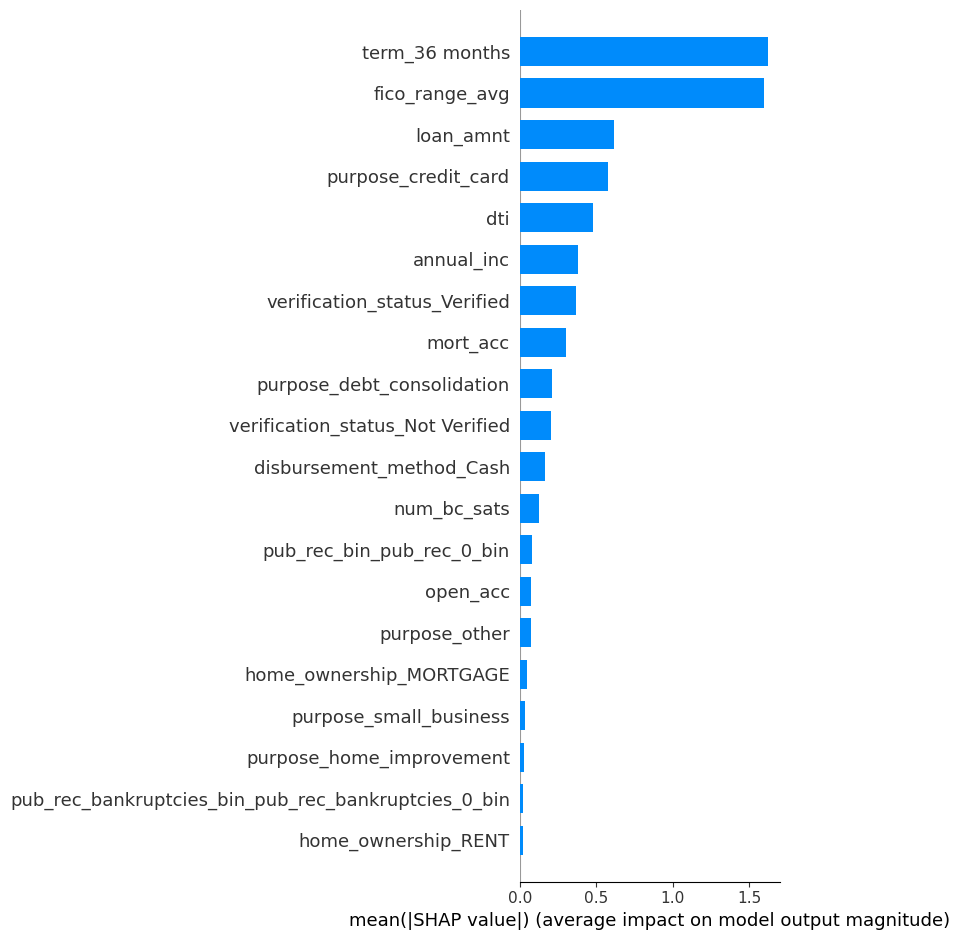

In [25]:
# Show SHAP Feature Importance

# Initiate JavaScript for visualization 
shap.initjs()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_encoded, feature_names=columns, plot_type='bar')

The below plot shows how the feature values affect the model output.

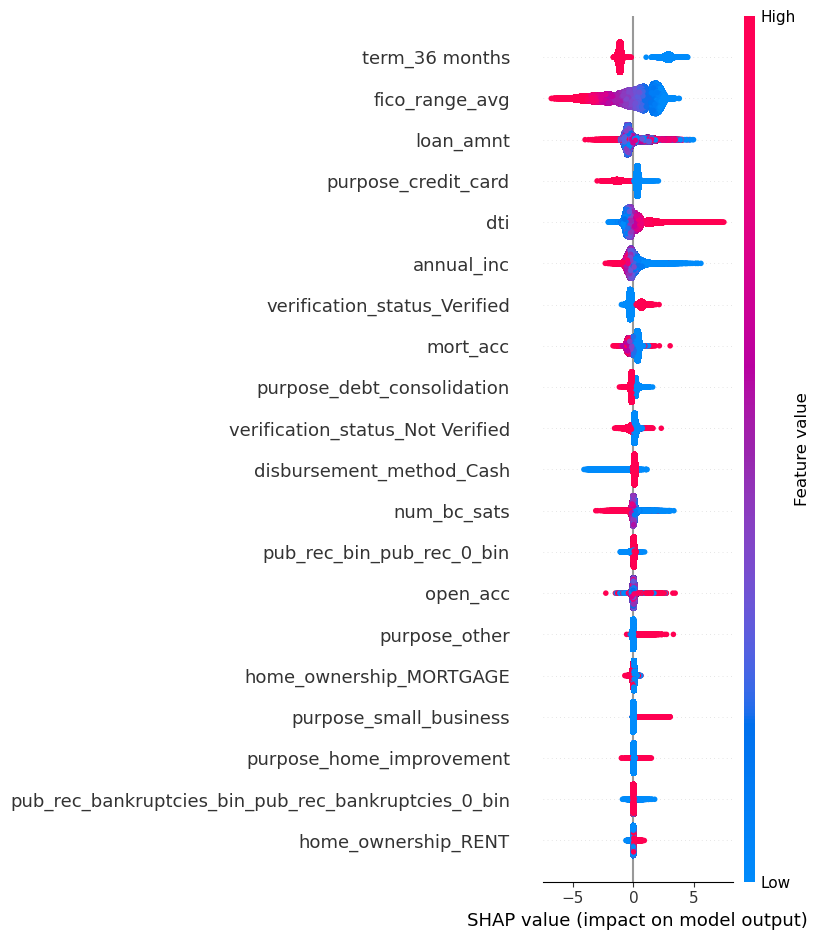

In [26]:
# Show SHAP Feature Importance impact on model output

# Initiate JavaScript for visualization 
shap.initjs()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_encoded, feature_names=columns)

Some observations:
- If loan term was '36 months', interest rates were lower.
- Higher FICO score has negative impact on interest rates.
- If the purpose of the loan was 'credit card refinancing', interest rates were lower.
- Higher dti (debt-to-income) ratio has positive impact on interest rates.
- Higher annual income has negative impact on interest rates.

Now let us try to predict using Validation and Test sets.

---
<a id="5"></a>
### 5. XG Boost: Model Predictions

**Predict on Validation set**

In [27]:
# Predict on Validation set
pred = xgb_fitgrid.best_estimator_.predict(X_validation)
print(pred)

[12.4455185 19.557957  13.507409  ... 11.974798  16.394104  13.474098 ]


In [28]:
# Predicted error
pred_error = y_validation - pred

In [29]:
# Show predicted error as a data frame
pd.DataFrame(pred_error)

,int_rate
2043400,-3.005518
1111111,-1.587957
1131976,-5.317409
1512342,-0.265703
749634,-1.931683
...,...
628988,-0.550967
274810,-0.506779
142964,2.015202
2222476,-2.404104


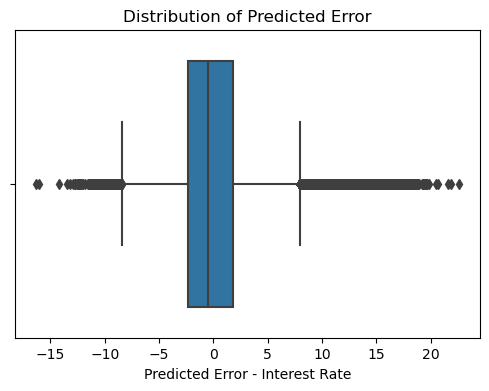

In [30]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

**Predict on Test set**

In [31]:
# Predict on Test set
pred = xgb_fitgrid.best_estimator_.predict(X_test)
print(pred)

[15.89534  17.439016 11.892371 ... 13.260922 14.03891   9.129262]


In [32]:
# Predicted error
pred_error = y_test - pred

In [33]:
# Actual vs Predicted interest rates
pd.DataFrame({'Actual': y_test, 'Predicted': pred, 'Error': pred_error})

,Actual,Predicted,Error
1592109,19.42,15.895340,3.524660
2103726,11.99,17.439016,-5.449016
2231437,13.49,11.892371,1.597629
1285218,14.16,14.390437,-0.230437
296051,21.67,15.150083,6.519917
...,...,...,...
507968,6.08,8.653562,-2.573562
747744,9.75,8.440784,1.309216
295840,13.99,13.260922,0.729078
572988,12.62,14.038910,-1.418910


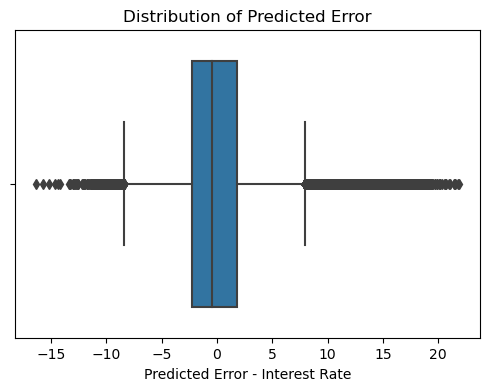

In [34]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

---
<a id="6"></a>
### 6. Observations

In [35]:
# Display both Best Estimator and SHAP top 10 Feature Importances data frames

display(feature_imp_df.head(10))

display(shap_imp_df.head(10))

,0
term_36 months,0.412653
fico_range_avg,0.122795
verification_status_Verified,0.078784
disbursement_method_Cash,0.069181
purpose_credit_card,0.068135
purpose_wedding,0.025919
verification_status_Not Verified,0.025501
purpose_debt_consolidation,0.021644
purpose_small_business,0.019435
loan_amnt,0.015070


,col_name,feature_importance
0,term_36 months,1.620562
36,fico_range_avg,1.596214
30,loan_amnt,0.619305
3,purpose_credit_card,0.577613
32,dti,0.481886
31,annual_inc,0.378532
18,verification_status_Verified,0.370952
34,mort_acc,0.302836
4,purpose_debt_consolidation,0.210732
16,verification_status_Not Verified,0.205725


Let us create a table to see the top 10 Feature Importances side-by-side.

||**Decision Tree**|**Decision Tree**|**Random Forest**|**XG Boost**|**XG Boost**|
|-|-|-|-|-|-|
||**GridSearchCV**|**SHAP**|**GridSearchCV**|**GridSearchCV**|**SHAP**|
|1|fico_range_avg|fico_range_avg|fico_range_avg|term_36 months|term_36 months|
|2|term_60 months|term_60_months|term_60 months|fico_range_avg|fico_range_avg|
|3|purpose_credit_card|purpose_credit_card|dti|verification_status_Verified|loan_amnt|
|4|dti|dti|annual_inc|disbursement_method_Cash|purpose_credit_card|
|5|annual_inc|annual_inc|loan_amnt|purpose_credit_card|dti|
|6|verification_status_Verified|verification_status_Verified|purpose_credit_card|purpose_wedding|annual_inc|
|7|loan_amnt|verification_status_Not Verified|verification_status_Verified|verification_status_Not Verified|verification_status_Verified|
|8|verification_status_Not Verified|mort_acc|open_acc|purpose_debt_consolidation|mort_acc|
|9|disbursement_method_DirectPay|loan_amnt|mort_acc|purpose_small_business|purpose_debt_consolidation|
|10|mort_acc|purpose_debt_consolidation|num_bc_sats|loan_amnt|verification_status_Not Verified|

Let us create a table for the RMSE scores.

||Best RMSE score|
|-|-|
|Model - Decision Tree Regressor (max_depth=15, min_samples_leaf=95)|-3.6514|
|Model - Random Forest Regressor (n_estimators=100, max_depth=20, min_samples_leaf=15)|-3.5783|
|Model - XG Boost Regressor (n_estimators=100, max_depth=10, eta=0.2)|-3.4922|

The best RMSE score for our best model (as of now) i.e. XG Boost Regressor (n_estimators=100, max_depth=10, eta=0.2) is ~ -3.50.

Based on the above RMSE scores, for the time being, we shall go ahead with the following model for our data set:

**XG Boost Regressor model (n_estimators=100, max_depth=10, eta=0.2)**

---
<a id="7"></a>
### 7. Future Steps

In future iterations of this analysis, we would like to:
- Include the ZIP CODE and STATE features to get a better understanding of how interest rates vary based on localities.
- Include the EMPLOYMENT TITLE and EMPLOYMENT LENGTH features to see how interest rates vary.
- Perform GridSearchCV instead of RandomizedSearchCV.
- Improve the RMSE score.
- Look at adding weights to certain features (not all features have equal importance).

**The End**